In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.preprocessing import StandardScaler
import joblib

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier


from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

## Загрузка и анализ данных

In [50]:
df = pd.read_csv("aug_train.csv")
df_id = df['enrollee_id']
df = df.drop('enrollee_id', axis=1)
df

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


In [51]:
df.isnull().sum()

city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [52]:
df['target'].value_counts() #дисбаланси класса

0.0    14381
1.0     4777
Name: target, dtype: int64

In [53]:
df=df.drop('city', axis=1)
df['experience'].unique()

array(['>20', '15', '5', '<1', '11', '13', '7', '17', '2', '16', '1', '4',
       '10', '14', '18', '19', '12', '3', '6', '9', '8', '20', nan],
      dtype=object)

In [54]:
df['education_level'].unique()

array(['Graduate', 'Masters', 'High School', nan, 'Phd', 'Primary School'],
      dtype=object)

In [55]:
df['last_new_job'].unique()

array(['1', '>4', 'never', '4', '3', '2', nan], dtype=object)

In [56]:
df['enrolled_university'].unique()

array(['no_enrollment', 'Full time course', nan, 'Part time course'],
      dtype=object)

In [57]:
df['enrolled_university'].unique()

array(['no_enrollment', 'Full time course', nan, 'Part time course'],
      dtype=object)

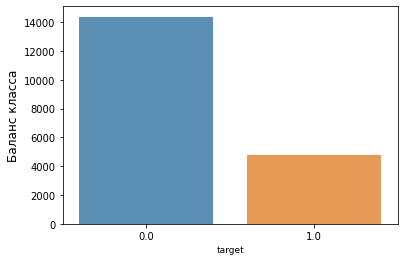

In [61]:
#Наблюдается разбалансировка значний класса
value_count_target = df['target'].value_counts()  
plt.figure(figsize=(6,4))
sns.barplot(value_count_target.index, value_count_target.values, alpha=0.8)
plt.ylabel('Баланс класса', fontsize=12)
plt.xlabel('target', fontsize=9)
plt.xticks()
plt.show()

array([[<AxesSubplot:title={'center':'city_development_index'}>,
        <AxesSubplot:title={'center':'training_hours'}>],
       [<AxesSubplot:title={'center':'target'}>, <AxesSubplot:>]],
      dtype=object)

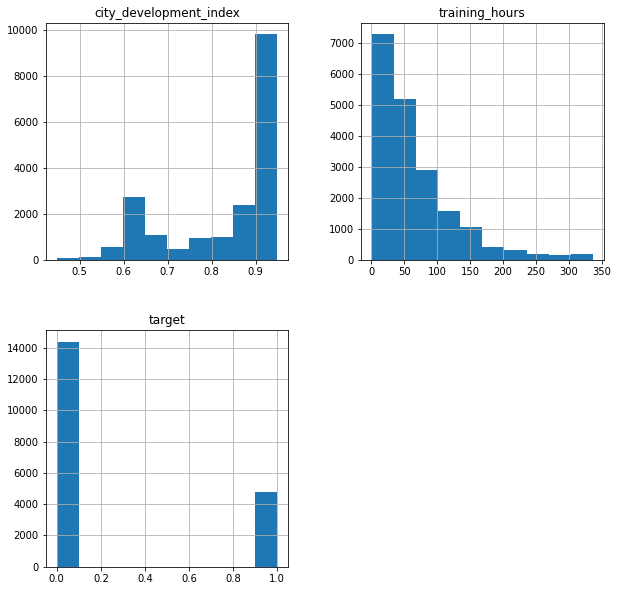

In [62]:
df.hist(figsize=(10, 10))

In [60]:
df.describe()

,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000
mean,0.828848,65.366896,0.249348
std,0.123362,60.058462,0.432647
min,0.448000,1.000000,0.000000
25%,0.740000,23.000000,0.000000
50%,0.903000,47.000000,0.000000
75%,0.920000,88.000000,0.000000
max,0.949000,336.000000,1.000000


## Обработка пропущенных значений

In [11]:
#Там, где мало пропущенных значений, заменю их модой. Думаю сильно это модель не испортит
df['enrolled_university'] = df['enrolled_university'].fillna(df['enrolled_university'].mode()[0])
df['education_level'] = df['education_level'].fillna(df['education_level'].mode()[0])
df['last_new_job'] = df['last_new_job'].fillna(df['last_new_job'].mode()[0])
df['experience'] = df['experience'].fillna(df['experience'].mode()[0])

In [12]:
#В случае столбцов с большим колисетсво пропусков, воспользуюсь алгоритмом машинного обучения,
#Чтобы повысить качество заполнения значений

def pred_data(column, col_clusters):  
    """
    Функция выделяет из датафрейма столбцы с большим количетсвом пропусков.
    Затем предсказывает пропуски на основе имеющихся данных в заполненых столбцах с 
    помощью алгоритма KNeighborsClassifier. Нужно передать количество кластеров
    col_clusters и column - название столбца с пропущенными значениями, которые следует
    предсказать. Возвращает объект pandas dataframe с заполенным столбцом и печатает 
    отчёт о качестве предсказания.
    """
    
    list_nan = ['gender', 'major_discipline', 'company_size', 'company_type']
    pred_nan = [i for i in df.columns if i not in list_nan]
    pred_nan.append(column)
    df_train_nan = df[pred_nan].dropna()
    df_test_nan = df[df[pred_nan].isnull().any(axis=1)][pred_nan]
    id_pred_test = df_test_nan.index
    id_pred_train = df_train_nan.index
    to_dummies = ['relevent_experience', 'enrolled_university', 'education_level', 'experience',
                 'last_new_job', 'training_hours', column]
    df_train_nan = ce.OrdinalEncoder(cols=to_dummies).fit_transform(df_train_nan)
    df_test_nan = ce.OrdinalEncoder(cols=to_dummies).fit_transform(df_test_nan)

    X_train, X_valid, y_train, y_valid = train_test_split(df_train_nan.drop(column, axis=1), df_train_nan[column],
                                                          test_size=0.3, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.fit_transform(X_valid)
    X_test = scaler.fit_transform(df_test_nan.drop(column, axis=1))
    model = RandomForestClassifier(bootstrap=True, class_weight="balanced",
                      criterion='gini', max_depth=10,
                      max_features='auto',
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_samples_split=2)

    model.fit(X_train, y_train)
    err = classification_report(model.predict(X_valid), y_valid)
    pred = model.predict(X_test)
    print(err)
    
    frame_test = pd.DataFrame(pred, index=id_pred_test, columns=[column])
    frame_train = pd.DataFrame(df_train_nan[column], index=id_pred_train, columns=[column])
    frame =  pd.concat([frame_test, frame_train]).sort_index()
    
    return frame

In [13]:
#Качество хромает, но всё же лучше, чем мода.
frame_gender = pred_data('gender', 8)
df['gender'] = frame_gender
frame_major_discipline = pred_data('major_discipline', 8)
df['major_discipline'] = frame_major_discipline
frame_company_type = pred_data('company_type', 8)
df['company_type'] = frame_company_type
frame_company_size = pred_data('company_size', 8)
df['company_size'] = frame_company_size

              precision    recall  f1-score   support

           1       0.87      0.90      0.89      3777
           2       0.19      0.14      0.16       556
           3       0.02      0.02      0.02        62

    accuracy                           0.79      4395
   macro avg       0.36      0.35      0.35      4395
weighted avg       0.77      0.79      0.78      4395

              precision    recall  f1-score   support

           1       0.77      0.91      0.83      3678
           2       0.02      0.02      0.02        89
           3       0.20      0.03      0.05       545
           4       0.18      0.09      0.12       373
           5       0.06      0.04      0.05        98
           6       0.03      0.02      0.03       121

    accuracy                           0.69      4904
   macro avg       0.21      0.19      0.18      4904
weighted avg       0.61      0.69      0.64      4904

              precision    recall  f1-score   support

           1       0.

In [14]:
df

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,0.920,1,Has relevent experience,no_enrollment,Graduate,1,>20,5,1,1,36,1.0
1,0.776,1,No relevent experience,no_enrollment,Graduate,1,15,1,1,>4,47,0.0
2,0.624,1,No relevent experience,Full time course,Graduate,1,5,2,1,never,83,0.0
3,0.789,1,No relevent experience,no_enrollment,Graduate,2,<1,8,1,never,52,1.0
4,0.767,1,Has relevent experience,no_enrollment,Masters,1,>20,1,2,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19153,0.878,1,No relevent experience,no_enrollment,Graduate,4,14,8,1,1,42,1.0
19154,0.920,1,Has relevent experience,no_enrollment,Graduate,1,14,7,5,4,52,1.0
19155,0.920,1,Has relevent experience,no_enrollment,Graduate,1,>20,1,1,4,44,0.0
19156,0.802,1,Has relevent experience,no_enrollment,High School,5,<1,8,1,2,97,0.0


## Энкодинг значений

In [15]:
df['gender'].unique()

array([1, 2, 3])

In [16]:
to_dummies = ['relevent_experience', 'enrolled_university', 'enrolled_university',
             'experience', 'last_new_job', 'education_level', 'gender', 
              'major_discipline', 'company_size', 'company_type']
df = pd.get_dummies(df, columns=to_dummies, drop_first=True)

## Снижение размерности с помощью перкрёсной проверки

In [17]:
#Сперва стандартизирую непрервыные признаки
scaler = StandardScaler()
df_scale = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df['city_development_index'] = df_scale['city_development_index']
df['training_hours'] = df_scale['training_hours']

In [18]:
target = df['target']
df_train = df.drop('target', axis=1)

In [19]:
rand_model = RandomForestClassifier(bootstrap=True, class_weight="balanced",
                      criterion='gini', max_depth=10,
                      max_features='auto',
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_samples_split=2, n_jobs=-1)

rfecv = RFECV(estimator=rand_model, step=2, scoring="accuracy")
rfecv.fit(df_train, target)
rfecv.fit(df_train, target)
print(rfecv.support_)
print(rfecv.n_features_)
rfecv.transform(df_train)

[ True  True  True  True  True  True  True False False False False False
 False False False False False  True False  True False False False False
 False False  True  True  True False False  True  True  True  True False
  True  True False False False False False False  True  True False  True
  True  True False  True  True False  True False]
26


array([[ 0.73891926, -0.4889846 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.42840976, -0.30582494,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.66059039,  0.29360665,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.73891926, -0.35577758,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.21764202,  0.52671894,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.21199991,  1.02624527,  1.        , ...,  0.        ,
         0.        ,  0.        ]])

In [20]:
df_train = rfecv.transform(df_train)

## Построение модели

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train, np.array(target), 
                                                      test_size=0.25, random_state=42)

In [28]:
search_space = {"n_estimators": [10, 50, 100, 1000],
                "max_features": [1, 2, 3, 4, 5]}
gridsearch = GridSearchCV(RandomForestClassifier(n_jobs=-1), search_space, cv=5, verbose=0, scoring='accuracy')
random_best_model = gridsearch.fit(X_train, y_train)

In [29]:
random_best_model.score(X_valid, y_valid)

0.7574112734864301

In [30]:
search_space = {"n_estimators": [10, 50, 100, 1000],
                }
gridsearch = GridSearchCV(AdaBoostClassifier(), search_space, cv=5, verbose=0, scoring='accuracy')
ada_best_model = gridsearch.fit(X_train, y_train)

In [31]:
ada_best_model.score(X_valid, y_valid)

0.7676409185803758

In [32]:
search_space = {"penalty":['l1', 'l2'],
                 "C":[0.1, 0.5, 0.9, 10]
                }
gridsearch = GridSearchCV(LogisticRegression(), search_space, cv=5, verbose=0, scoring='accuracy')
logistic_best_model = gridsearch.fit(X_train, y_train)
logistic_best_model.score(X_valid, y_valid)

0.7626304801670146

In [35]:
search_space = {'depth'         : [6,8,10,],
              'learning_rate' : [0.01, 0.05, 0.1],
               'iterations'    : [10, 30, 50]
                 }
gridsearch = GridSearchCV(CatBoostClassifier(), search_space, cv=5, verbose=0, scoring='accuracy')
best_model = gridsearch.fit(X_train, y_train)
cat_best_model.score(X_valid, y_valid)

0:	learn: 0.6885704	total: 58.5ms	remaining: 526ms
1:	learn: 0.6839218	total: 64.3ms	remaining: 257ms
2:	learn: 0.6793445	total: 69.8ms	remaining: 163ms
3:	learn: 0.6749539	total: 75.4ms	remaining: 113ms
4:	learn: 0.6706255	total: 80.7ms	remaining: 80.7ms
5:	learn: 0.6663424	total: 85.2ms	remaining: 56.8ms
6:	learn: 0.6621115	total: 90.4ms	remaining: 38.7ms
7:	learn: 0.6579000	total: 95.7ms	remaining: 23.9ms
8:	learn: 0.6538444	total: 101ms	remaining: 11.2ms
9:	learn: 0.6500135	total: 106ms	remaining: 0us
0:	learn: 0.6885921	total: 6.11ms	remaining: 55ms
1:	learn: 0.6841467	total: 8.9ms	remaining: 35.6ms
2:	learn: 0.6795217	total: 13.7ms	remaining: 31.9ms
3:	learn: 0.6752480	total: 17.8ms	remaining: 26.8ms
4:	learn: 0.6711395	total: 22.5ms	remaining: 22.5ms
5:	learn: 0.6669975	total: 27ms	remaining: 18ms
6:	learn: 0.6626495	total: 31.5ms	remaining: 13.5ms
7:	learn: 0.6589184	total: 35.6ms	remaining: 8.9ms
8:	learn: 0.6550464	total: 40.5ms	remaining: 4.49ms
9:	learn: 0.6513259	total: 45

15:	learn: 0.6286475	total: 75ms	remaining: 65.7ms
16:	learn: 0.6254581	total: 80ms	remaining: 61.2ms
17:	learn: 0.6221500	total: 85.2ms	remaining: 56.8ms
18:	learn: 0.6188683	total: 90.8ms	remaining: 52.5ms
19:	learn: 0.6159633	total: 95.8ms	remaining: 47.9ms
20:	learn: 0.6130842	total: 101ms	remaining: 43.4ms
21:	learn: 0.6102437	total: 106ms	remaining: 38.7ms
22:	learn: 0.6072533	total: 112ms	remaining: 34ms
23:	learn: 0.6044152	total: 117ms	remaining: 29.2ms
24:	learn: 0.6015608	total: 121ms	remaining: 24.3ms
25:	learn: 0.5988310	total: 126ms	remaining: 19.4ms
26:	learn: 0.5962341	total: 131ms	remaining: 14.6ms
27:	learn: 0.5937148	total: 136ms	remaining: 9.72ms
28:	learn: 0.5911199	total: 141ms	remaining: 4.86ms
29:	learn: 0.5886361	total: 147ms	remaining: 0us
0:	learn: 0.6885921	total: 5.96ms	remaining: 173ms
1:	learn: 0.6841467	total: 9.1ms	remaining: 127ms
2:	learn: 0.6795217	total: 14.3ms	remaining: 129ms
3:	learn: 0.6752480	total: 19.3ms	remaining: 125ms
4:	learn: 0.6711395	t

0:	learn: 0.6709414	total: 5.85ms	remaining: 170ms
1:	learn: 0.6502015	total: 11.3ms	remaining: 159ms
2:	learn: 0.6317297	total: 16.7ms	remaining: 150ms
3:	learn: 0.6156031	total: 22.4ms	remaining: 145ms
4:	learn: 0.6012271	total: 27.7ms	remaining: 139ms
5:	learn: 0.5878176	total: 33.2ms	remaining: 133ms
6:	learn: 0.5760032	total: 38.6ms	remaining: 127ms
7:	learn: 0.5649490	total: 44.4ms	remaining: 122ms
8:	learn: 0.5552847	total: 50.3ms	remaining: 117ms
9:	learn: 0.5468714	total: 55.8ms	remaining: 112ms
10:	learn: 0.5400478	total: 60.6ms	remaining: 105ms
11:	learn: 0.5339209	total: 63.1ms	remaining: 94.7ms
12:	learn: 0.5273872	total: 67.8ms	remaining: 88.7ms
13:	learn: 0.5220122	total: 72.5ms	remaining: 82.8ms
14:	learn: 0.5169188	total: 77.5ms	remaining: 77.5ms
15:	learn: 0.5122144	total: 82.9ms	remaining: 72.5ms
16:	learn: 0.5073708	total: 88.5ms	remaining: 67.7ms
17:	learn: 0.5041805	total: 93.8ms	remaining: 62.5ms
18:	learn: 0.5014713	total: 96.8ms	remaining: 56ms
19:	learn: 0.498

0:	learn: 0.6495911	total: 5.2ms	remaining: 151ms
1:	learn: 0.6141567	total: 10.9ms	remaining: 152ms
2:	learn: 0.5868325	total: 16.2ms	remaining: 146ms
3:	learn: 0.5643360	total: 21.4ms	remaining: 139ms
4:	learn: 0.5465498	total: 26.6ms	remaining: 133ms
5:	learn: 0.5319220	total: 31ms	remaining: 124ms
6:	learn: 0.5180778	total: 36ms	remaining: 118ms
7:	learn: 0.5078316	total: 40.9ms	remaining: 112ms
8:	learn: 0.4992746	total: 45.7ms	remaining: 107ms
9:	learn: 0.4933647	total: 50.6ms	remaining: 101ms
10:	learn: 0.4884834	total: 55.6ms	remaining: 96ms
11:	learn: 0.4836435	total: 60.4ms	remaining: 90.6ms
12:	learn: 0.4797458	total: 65.4ms	remaining: 85.5ms
13:	learn: 0.4766624	total: 70.3ms	remaining: 80.3ms
14:	learn: 0.4735868	total: 75.1ms	remaining: 75.1ms
15:	learn: 0.4712854	total: 79.8ms	remaining: 69.8ms
16:	learn: 0.4688716	total: 84.7ms	remaining: 64.8ms
17:	learn: 0.4667262	total: 89.6ms	remaining: 59.8ms
18:	learn: 0.4647980	total: 95.1ms	remaining: 55ms
19:	learn: 0.4630744	t

44:	learn: 0.5584725	total: 223ms	remaining: 24.7ms
45:	learn: 0.5566188	total: 228ms	remaining: 19.8ms
46:	learn: 0.5550632	total: 234ms	remaining: 14.9ms
47:	learn: 0.5532318	total: 240ms	remaining: 9.98ms
48:	learn: 0.5517480	total: 245ms	remaining: 4.99ms
49:	learn: 0.5501926	total: 250ms	remaining: 0us
0:	learn: 0.6885306	total: 5.37ms	remaining: 263ms
1:	learn: 0.6838041	total: 11ms	remaining: 265ms
2:	learn: 0.6791712	total: 16.3ms	remaining: 255ms
3:	learn: 0.6748104	total: 21.6ms	remaining: 248ms
4:	learn: 0.6705087	total: 27.3ms	remaining: 246ms
5:	learn: 0.6662317	total: 33.7ms	remaining: 247ms
6:	learn: 0.6620109	total: 39.4ms	remaining: 242ms
7:	learn: 0.6578094	total: 45.6ms	remaining: 240ms
8:	learn: 0.6536971	total: 51.4ms	remaining: 234ms
9:	learn: 0.6498546	total: 56.9ms	remaining: 228ms
10:	learn: 0.6461176	total: 62.8ms	remaining: 223ms
11:	learn: 0.6425806	total: 65.9ms	remaining: 209ms
12:	learn: 0.6388080	total: 71.8ms	remaining: 204ms
13:	learn: 0.6350740	total:

7:	learn: 0.5637163	total: 40.8ms	remaining: 214ms
8:	learn: 0.5538580	total: 45.9ms	remaining: 209ms
9:	learn: 0.5455936	total: 50.9ms	remaining: 204ms
10:	learn: 0.5385244	total: 55.8ms	remaining: 198ms
11:	learn: 0.5322986	total: 58.5ms	remaining: 185ms
12:	learn: 0.5264051	total: 64.5ms	remaining: 184ms
13:	learn: 0.5215744	total: 70.2ms	remaining: 181ms
14:	learn: 0.5159469	total: 75.9ms	remaining: 177ms
15:	learn: 0.5119161	total: 80.8ms	remaining: 172ms
16:	learn: 0.5077466	total: 85.6ms	remaining: 166ms
17:	learn: 0.5039434	total: 90.8ms	remaining: 161ms
18:	learn: 0.5000899	total: 96.9ms	remaining: 158ms
19:	learn: 0.4969270	total: 103ms	remaining: 154ms
20:	learn: 0.4941758	total: 109ms	remaining: 150ms
21:	learn: 0.4916791	total: 114ms	remaining: 145ms
22:	learn: 0.4887250	total: 120ms	remaining: 140ms
23:	learn: 0.4865162	total: 125ms	remaining: 136ms
24:	learn: 0.4846093	total: 130ms	remaining: 130ms
25:	learn: 0.4825692	total: 136ms	remaining: 125ms
26:	learn: 0.4802871	t

48:	learn: 0.4609785	total: 261ms	remaining: 5.33ms
49:	learn: 0.4604531	total: 267ms	remaining: 0us
0:	learn: 0.6710975	total: 5.4ms	remaining: 265ms
1:	learn: 0.6511318	total: 8.54ms	remaining: 205ms
2:	learn: 0.6319950	total: 14.2ms	remaining: 222ms
3:	learn: 0.6164017	total: 19.9ms	remaining: 229ms
4:	learn: 0.6019758	total: 25.3ms	remaining: 227ms
5:	learn: 0.5879478	total: 31ms	remaining: 227ms
6:	learn: 0.5758450	total: 36.6ms	remaining: 225ms
7:	learn: 0.5653393	total: 42.4ms	remaining: 223ms
8:	learn: 0.5562662	total: 47.8ms	remaining: 218ms
9:	learn: 0.5486108	total: 53.2ms	remaining: 213ms
10:	learn: 0.5403290	total: 58.8ms	remaining: 208ms
11:	learn: 0.5329900	total: 65.7ms	remaining: 208ms
12:	learn: 0.5271210	total: 71.4ms	remaining: 203ms
13:	learn: 0.5214200	total: 76.7ms	remaining: 197ms
14:	learn: 0.5161264	total: 82.5ms	remaining: 193ms
15:	learn: 0.5113043	total: 88.4ms	remaining: 188ms
16:	learn: 0.5076456	total: 94.3ms	remaining: 183ms
17:	learn: 0.5035127	total: 

11:	learn: 0.4836435	total: 61.8ms	remaining: 196ms
12:	learn: 0.4797458	total: 67.6ms	remaining: 192ms
13:	learn: 0.4766624	total: 73ms	remaining: 188ms
14:	learn: 0.4735868	total: 78.3ms	remaining: 183ms
15:	learn: 0.4712854	total: 83.1ms	remaining: 177ms
16:	learn: 0.4688716	total: 88.3ms	remaining: 171ms
17:	learn: 0.4667262	total: 93.8ms	remaining: 167ms
18:	learn: 0.4647980	total: 99.9ms	remaining: 163ms
19:	learn: 0.4630744	total: 105ms	remaining: 158ms
20:	learn: 0.4619131	total: 111ms	remaining: 153ms
21:	learn: 0.4603948	total: 116ms	remaining: 148ms
22:	learn: 0.4592383	total: 122ms	remaining: 143ms
23:	learn: 0.4582528	total: 127ms	remaining: 138ms
24:	learn: 0.4572904	total: 133ms	remaining: 133ms
25:	learn: 0.4562688	total: 138ms	remaining: 127ms
26:	learn: 0.4554213	total: 143ms	remaining: 122ms
27:	learn: 0.4545659	total: 148ms	remaining: 116ms
28:	learn: 0.4536177	total: 153ms	remaining: 111ms
29:	learn: 0.4526103	total: 157ms	remaining: 105ms
30:	learn: 0.4518210	tota

1:	learn: 0.6839834	total: 15.5ms	remaining: 62ms
2:	learn: 0.6793243	total: 25.2ms	remaining: 58.8ms
3:	learn: 0.6750234	total: 29ms	remaining: 43.5ms
4:	learn: 0.6708722	total: 39.5ms	remaining: 39.5ms
5:	learn: 0.6668830	total: 42.8ms	remaining: 28.5ms
6:	learn: 0.6622880	total: 53.7ms	remaining: 23ms
7:	learn: 0.6584087	total: 57.8ms	remaining: 14.4ms
8:	learn: 0.6544733	total: 68.3ms	remaining: 7.58ms
9:	learn: 0.6503443	total: 79.2ms	remaining: 0us
0:	learn: 0.6886249	total: 6.45ms	remaining: 58.1ms
1:	learn: 0.6839514	total: 16.7ms	remaining: 66.7ms
2:	learn: 0.6792479	total: 27.7ms	remaining: 64.7ms
3:	learn: 0.6749256	total: 31.7ms	remaining: 47.6ms
4:	learn: 0.6703607	total: 40.8ms	remaining: 40.8ms
5:	learn: 0.6663438	total: 45.1ms	remaining: 30.1ms
6:	learn: 0.6621864	total: 55.6ms	remaining: 23.8ms
7:	learn: 0.6579020	total: 66.3ms	remaining: 16.6ms
8:	learn: 0.6539341	total: 76.8ms	remaining: 8.54ms
9:	learn: 0.6498909	total: 88.2ms	remaining: 0us
0:	learn: 0.6708315	tota

20:	learn: 0.6112096	total: 207ms	remaining: 88.8ms
21:	learn: 0.6081414	total: 213ms	remaining: 77.3ms
22:	learn: 0.6049338	total: 224ms	remaining: 68.2ms
23:	learn: 0.6020377	total: 234ms	remaining: 58.4ms
24:	learn: 0.5990187	total: 244ms	remaining: 48.8ms
25:	learn: 0.5963189	total: 253ms	remaining: 38.9ms
26:	learn: 0.5936262	total: 276ms	remaining: 30.7ms
27:	learn: 0.5909578	total: 287ms	remaining: 20.5ms
28:	learn: 0.5880243	total: 298ms	remaining: 10.3ms
29:	learn: 0.5854024	total: 308ms	remaining: 0us
0:	learn: 0.6885306	total: 6.51ms	remaining: 189ms
1:	learn: 0.6835930	total: 15.7ms	remaining: 219ms
2:	learn: 0.6788373	total: 25.3ms	remaining: 228ms
3:	learn: 0.6745185	total: 29ms	remaining: 188ms
4:	learn: 0.6699217	total: 38.3ms	remaining: 191ms
5:	learn: 0.6658865	total: 41.2ms	remaining: 165ms
6:	learn: 0.6617771	total: 52.5ms	remaining: 172ms
7:	learn: 0.6578896	total: 57ms	remaining: 157ms
8:	learn: 0.6538876	total: 67.9ms	remaining: 158ms
9:	learn: 0.6501983	total: 7

3:	learn: 0.6132184	total: 28ms	remaining: 182ms
4:	learn: 0.5988971	total: 37.5ms	remaining: 187ms
5:	learn: 0.5865284	total: 40.3ms	remaining: 161ms
6:	learn: 0.5727881	total: 51ms	remaining: 168ms
7:	learn: 0.5624133	total: 54.5ms	remaining: 150ms
8:	learn: 0.5516522	total: 64.1ms	remaining: 150ms
9:	learn: 0.5430315	total: 72.1ms	remaining: 144ms
10:	learn: 0.5353537	total: 82.5ms	remaining: 142ms
11:	learn: 0.5283201	total: 93.7ms	remaining: 141ms
12:	learn: 0.5218444	total: 105ms	remaining: 137ms
13:	learn: 0.5154873	total: 116ms	remaining: 132ms
14:	learn: 0.5109338	total: 121ms	remaining: 121ms
15:	learn: 0.5074090	total: 124ms	remaining: 108ms
16:	learn: 0.5022185	total: 135ms	remaining: 103ms
17:	learn: 0.4978888	total: 145ms	remaining: 96.6ms
18:	learn: 0.4939390	total: 155ms	remaining: 90ms
19:	learn: 0.4897395	total: 166ms	remaining: 83.1ms
20:	learn: 0.4871934	total: 177ms	remaining: 75.7ms
21:	learn: 0.4841767	total: 188ms	remaining: 68.2ms
22:	learn: 0.4811164	total: 19

24:	learn: 0.4439155	total: 237ms	remaining: 47.4ms
25:	learn: 0.4424631	total: 248ms	remaining: 38.1ms
26:	learn: 0.4411202	total: 258ms	remaining: 28.6ms
27:	learn: 0.4393863	total: 269ms	remaining: 19.2ms
28:	learn: 0.4385307	total: 279ms	remaining: 9.61ms
29:	learn: 0.4370594	total: 288ms	remaining: 0us
0:	learn: 0.6506813	total: 6.25ms	remaining: 181ms
1:	learn: 0.6130630	total: 15ms	remaining: 210ms
2:	learn: 0.5837970	total: 26.2ms	remaining: 236ms
3:	learn: 0.5624547	total: 31ms	remaining: 201ms
4:	learn: 0.5448132	total: 41.8ms	remaining: 209ms
5:	learn: 0.5319313	total: 45.2ms	remaining: 181ms
6:	learn: 0.5195548	total: 55.9ms	remaining: 184ms
7:	learn: 0.5088291	total: 66.7ms	remaining: 183ms
8:	learn: 0.4998480	total: 77.4ms	remaining: 181ms
9:	learn: 0.4918913	total: 88.4ms	remaining: 177ms
10:	learn: 0.4862022	total: 98.3ms	remaining: 170ms
11:	learn: 0.4803234	total: 108ms	remaining: 162ms
12:	learn: 0.4764927	total: 119ms	remaining: 156ms
13:	learn: 0.4727934	total: 130

1:	learn: 0.6835930	total: 14.1ms	remaining: 337ms
2:	learn: 0.6788373	total: 25.7ms	remaining: 403ms
3:	learn: 0.6745185	total: 30.1ms	remaining: 346ms
4:	learn: 0.6699217	total: 40.5ms	remaining: 365ms
5:	learn: 0.6658865	total: 44.1ms	remaining: 324ms
6:	learn: 0.6617771	total: 54.6ms	remaining: 336ms
7:	learn: 0.6578896	total: 58.8ms	remaining: 309ms
8:	learn: 0.6538876	total: 69.3ms	remaining: 316ms
9:	learn: 0.6501983	total: 73.6ms	remaining: 294ms
10:	learn: 0.6460081	total: 84.2ms	remaining: 298ms
11:	learn: 0.6423731	total: 93.7ms	remaining: 297ms
12:	learn: 0.6383428	total: 104ms	remaining: 296ms
13:	learn: 0.6346325	total: 110ms	remaining: 283ms
14:	learn: 0.6309937	total: 121ms	remaining: 282ms
15:	learn: 0.6274237	total: 131ms	remaining: 279ms
16:	learn: 0.6237992	total: 140ms	remaining: 272ms
17:	learn: 0.6202169	total: 149ms	remaining: 265ms
18:	learn: 0.6164693	total: 160ms	remaining: 261ms
19:	learn: 0.6132668	total: 169ms	remaining: 254ms
20:	learn: 0.6099211	total: 1

28:	learn: 0.4664634	total: 275ms	remaining: 199ms
29:	learn: 0.4647184	total: 285ms	remaining: 190ms
30:	learn: 0.4632145	total: 294ms	remaining: 180ms
31:	learn: 0.4616697	total: 305ms	remaining: 172ms
32:	learn: 0.4608031	total: 314ms	remaining: 162ms
33:	learn: 0.4593452	total: 326ms	remaining: 153ms
34:	learn: 0.4583232	total: 336ms	remaining: 144ms
35:	learn: 0.4571700	total: 347ms	remaining: 135ms
36:	learn: 0.4558823	total: 358ms	remaining: 126ms
37:	learn: 0.4548849	total: 368ms	remaining: 116ms
38:	learn: 0.4535190	total: 379ms	remaining: 107ms
39:	learn: 0.4525594	total: 390ms	remaining: 97.5ms
40:	learn: 0.4515735	total: 401ms	remaining: 88.1ms
41:	learn: 0.4504817	total: 412ms	remaining: 78.6ms
42:	learn: 0.4495140	total: 423ms	remaining: 68.9ms
43:	learn: 0.4485610	total: 436ms	remaining: 59.4ms
44:	learn: 0.4475455	total: 447ms	remaining: 49.6ms
45:	learn: 0.4468925	total: 457ms	remaining: 39.8ms
46:	learn: 0.4459015	total: 468ms	remaining: 29.9ms
47:	learn: 0.4450357	to

43:	learn: 0.4524323	total: 433ms	remaining: 59.1ms
44:	learn: 0.4515964	total: 444ms	remaining: 49.4ms
45:	learn: 0.4506194	total: 455ms	remaining: 39.5ms
46:	learn: 0.4498181	total: 465ms	remaining: 29.7ms
47:	learn: 0.4490647	total: 476ms	remaining: 19.8ms
48:	learn: 0.4483583	total: 485ms	remaining: 9.91ms
49:	learn: 0.4479045	total: 496ms	remaining: 0us
0:	learn: 0.6710975	total: 7.3ms	remaining: 358ms
1:	learn: 0.6500833	total: 15ms	remaining: 360ms
2:	learn: 0.6307871	total: 26ms	remaining: 407ms
3:	learn: 0.6148090	total: 30.3ms	remaining: 348ms
4:	learn: 0.6003800	total: 40.2ms	remaining: 362ms
5:	learn: 0.5880309	total: 43.1ms	remaining: 316ms
6:	learn: 0.5753528	total: 52.9ms	remaining: 325ms
7:	learn: 0.5648392	total: 56.7ms	remaining: 298ms
8:	learn: 0.5537598	total: 67ms	remaining: 305ms
9:	learn: 0.5452247	total: 76.2ms	remaining: 305ms
10:	learn: 0.5363059	total: 86.9ms	remaining: 308ms
11:	learn: 0.5294396	total: 97ms	remaining: 307ms
12:	learn: 0.5230981	total: 107ms	

21:	learn: 0.4481082	total: 206ms	remaining: 262ms
22:	learn: 0.4468986	total: 217ms	remaining: 254ms
23:	learn: 0.4452671	total: 228ms	remaining: 247ms
24:	learn: 0.4439155	total: 239ms	remaining: 239ms
25:	learn: 0.4424631	total: 249ms	remaining: 230ms
26:	learn: 0.4411202	total: 261ms	remaining: 222ms
27:	learn: 0.4393863	total: 272ms	remaining: 213ms
28:	learn: 0.4385307	total: 284ms	remaining: 206ms
29:	learn: 0.4370594	total: 295ms	remaining: 196ms
30:	learn: 0.4357302	total: 305ms	remaining: 187ms
31:	learn: 0.4349019	total: 316ms	remaining: 178ms
32:	learn: 0.4340698	total: 326ms	remaining: 168ms
33:	learn: 0.4332328	total: 337ms	remaining: 159ms
34:	learn: 0.4323614	total: 346ms	remaining: 148ms
35:	learn: 0.4315610	total: 357ms	remaining: 139ms
36:	learn: 0.4303608	total: 367ms	remaining: 129ms
37:	learn: 0.4295551	total: 378ms	remaining: 119ms
38:	learn: 0.4286380	total: 388ms	remaining: 110ms
39:	learn: 0.4278130	total: 401ms	remaining: 100ms
40:	learn: 0.4272760	total: 413

4:	learn: 0.6695974	total: 89.1ms	remaining: 89.1ms
5:	learn: 0.6650141	total: 115ms	remaining: 76.8ms
6:	learn: 0.6602134	total: 142ms	remaining: 60.7ms
7:	learn: 0.6561275	total: 148ms	remaining: 37ms
8:	learn: 0.6516998	total: 173ms	remaining: 19.3ms
9:	learn: 0.6474120	total: 201ms	remaining: 0us
0:	learn: 0.6886249	total: 6.1ms	remaining: 54.9ms
1:	learn: 0.6839514	total: 14.1ms	remaining: 56.3ms
2:	learn: 0.6791915	total: 42.3ms	remaining: 98.7ms
3:	learn: 0.6741272	total: 71.5ms	remaining: 107ms
4:	learn: 0.6696511	total: 92.6ms	remaining: 92.6ms
5:	learn: 0.6647927	total: 120ms	remaining: 79.8ms
6:	learn: 0.6599276	total: 147ms	remaining: 63.2ms
7:	learn: 0.6558175	total: 154ms	remaining: 38.4ms
8:	learn: 0.6512436	total: 182ms	remaining: 20.2ms
9:	learn: 0.6468849	total: 209ms	remaining: 0us
0:	learn: 0.6708315	total: 6.33ms	remaining: 57ms
1:	learn: 0.6486973	total: 15.5ms	remaining: 62.1ms
2:	learn: 0.6288576	total: 43ms	remaining: 100ms
3:	learn: 0.6094889	total: 72.4ms	rem

19:	learn: 0.6105683	total: 411ms	remaining: 206ms
20:	learn: 0.6075098	total: 423ms	remaining: 181ms
21:	learn: 0.6041230	total: 451ms	remaining: 164ms
22:	learn: 0.6008749	total: 480ms	remaining: 146ms
23:	learn: 0.5979846	total: 499ms	remaining: 125ms
24:	learn: 0.5956174	total: 502ms	remaining: 100ms
25:	learn: 0.5926160	total: 531ms	remaining: 81.6ms
26:	learn: 0.5895167	total: 559ms	remaining: 62.1ms
27:	learn: 0.5865157	total: 589ms	remaining: 42.1ms
28:	learn: 0.5837379	total: 619ms	remaining: 21.3ms
29:	learn: 0.5808461	total: 648ms	remaining: 0us
0:	learn: 0.6885306	total: 5.95ms	remaining: 172ms
1:	learn: 0.6835930	total: 13.9ms	remaining: 194ms
2:	learn: 0.6785237	total: 40.6ms	remaining: 366ms
3:	learn: 0.6734012	total: 67.8ms	remaining: 441ms
4:	learn: 0.6688839	total: 90.2ms	remaining: 451ms
5:	learn: 0.6639845	total: 117ms	remaining: 469ms
6:	learn: 0.6592016	total: 144ms	remaining: 474ms
7:	learn: 0.6550766	total: 150ms	remaining: 414ms
8:	learn: 0.6504654	total: 178ms

0:	learn: 0.6706448	total: 6.09ms	remaining: 177ms
1:	learn: 0.6485905	total: 13.9ms	remaining: 195ms
2:	learn: 0.6277775	total: 42ms	remaining: 378ms
3:	learn: 0.6084930	total: 68.6ms	remaining: 446ms
4:	learn: 0.5920624	total: 95.9ms	remaining: 479ms
5:	learn: 0.5773548	total: 124ms	remaining: 496ms
6:	learn: 0.5632951	total: 153ms	remaining: 504ms
7:	learn: 0.5528559	total: 160ms	remaining: 440ms
8:	learn: 0.5415598	total: 187ms	remaining: 436ms
9:	learn: 0.5316753	total: 213ms	remaining: 426ms
10:	learn: 0.5232235	total: 241ms	remaining: 417ms
11:	learn: 0.5150837	total: 270ms	remaining: 405ms
12:	learn: 0.5086630	total: 299ms	remaining: 391ms
13:	learn: 0.5021792	total: 327ms	remaining: 374ms
14:	learn: 0.4963116	total: 355ms	remaining: 355ms
15:	learn: 0.4917136	total: 383ms	remaining: 335ms
16:	learn: 0.4884318	total: 388ms	remaining: 297ms
17:	learn: 0.4838533	total: 418ms	remaining: 279ms
18:	learn: 0.4797998	total: 444ms	remaining: 257ms
19:	learn: 0.4755866	total: 472ms	rema

19:	learn: 0.4346899	total: 475ms	remaining: 238ms
20:	learn: 0.4344016	total: 478ms	remaining: 205ms
21:	learn: 0.4323738	total: 507ms	remaining: 184ms
22:	learn: 0.4297478	total: 533ms	remaining: 162ms
23:	learn: 0.4279204	total: 562ms	remaining: 140ms
24:	learn: 0.4254421	total: 589ms	remaining: 118ms
25:	learn: 0.4237825	total: 618ms	remaining: 95.1ms
26:	learn: 0.4208309	total: 645ms	remaining: 71.6ms
27:	learn: 0.4187017	total: 676ms	remaining: 48.3ms
28:	learn: 0.4171184	total: 704ms	remaining: 24.3ms
29:	learn: 0.4157266	total: 733ms	remaining: 0us
0:	learn: 0.6506813	total: 6.45ms	remaining: 187ms
1:	learn: 0.6130630	total: 14.7ms	remaining: 206ms
2:	learn: 0.5811810	total: 42.7ms	remaining: 384ms
3:	learn: 0.5546268	total: 70.1ms	remaining: 456ms
4:	learn: 0.5350230	total: 95.4ms	remaining: 477ms
5:	learn: 0.5182548	total: 126ms	remaining: 505ms
6:	learn: 0.5041809	total: 154ms	remaining: 507ms
7:	learn: 0.4950424	total: 163ms	remaining: 449ms
8:	learn: 0.4855915	total: 189ms

47:	learn: 0.5411008	total: 1.08s	remaining: 45.1ms
48:	learn: 0.5397606	total: 1.08s	remaining: 22.2ms
49:	learn: 0.5380287	total: 1.11s	remaining: 0us
0:	learn: 0.6885306	total: 5.77ms	remaining: 283ms
1:	learn: 0.6835930	total: 13.5ms	remaining: 324ms
2:	learn: 0.6785237	total: 40.7ms	remaining: 638ms
3:	learn: 0.6734012	total: 68.9ms	remaining: 792ms
4:	learn: 0.6688839	total: 88ms	remaining: 792ms
5:	learn: 0.6639845	total: 114ms	remaining: 839ms
6:	learn: 0.6592016	total: 144ms	remaining: 883ms
7:	learn: 0.6550766	total: 150ms	remaining: 785ms
8:	learn: 0.6504654	total: 178ms	remaining: 810ms
9:	learn: 0.6460854	total: 203ms	remaining: 810ms
10:	learn: 0.6418970	total: 230ms	remaining: 816ms
11:	learn: 0.6381296	total: 250ms	remaining: 790ms
12:	learn: 0.6347630	total: 262ms	remaining: 746ms
13:	learn: 0.6307866	total: 291ms	remaining: 748ms
14:	learn: 0.6266873	total: 319ms	remaining: 744ms
15:	learn: 0.6226014	total: 345ms	remaining: 734ms
16:	learn: 0.6189261	total: 374ms	rema

11:	learn: 0.5172840	total: 249ms	remaining: 789ms
12:	learn: 0.5107930	total: 275ms	remaining: 783ms
13:	learn: 0.5055199	total: 281ms	remaining: 724ms
14:	learn: 0.5000256	total: 307ms	remaining: 717ms
15:	learn: 0.4961858	total: 311ms	remaining: 661ms
16:	learn: 0.4930752	total: 314ms	remaining: 609ms
17:	learn: 0.4880072	total: 341ms	remaining: 606ms
18:	learn: 0.4836029	total: 369ms	remaining: 602ms
19:	learn: 0.4794692	total: 398ms	remaining: 598ms
20:	learn: 0.4761166	total: 427ms	remaining: 590ms
21:	learn: 0.4742696	total: 431ms	remaining: 548ms
22:	learn: 0.4727612	total: 434ms	remaining: 509ms
23:	learn: 0.4702660	total: 453ms	remaining: 491ms
24:	learn: 0.4676553	total: 481ms	remaining: 481ms
25:	learn: 0.4649674	total: 509ms	remaining: 470ms
26:	learn: 0.4620565	total: 537ms	remaining: 457ms
27:	learn: 0.4593288	total: 565ms	remaining: 444ms
28:	learn: 0.4579686	total: 574ms	remaining: 415ms
29:	learn: 0.4557211	total: 601ms	remaining: 401ms
30:	learn: 0.4536796	total: 627

27:	learn: 0.4575871	total: 647ms	remaining: 509ms
28:	learn: 0.4552815	total: 673ms	remaining: 487ms
29:	learn: 0.4539575	total: 702ms	remaining: 468ms
30:	learn: 0.4512045	total: 729ms	remaining: 447ms
31:	learn: 0.4493854	total: 754ms	remaining: 424ms
32:	learn: 0.4478637	total: 783ms	remaining: 404ms
33:	learn: 0.4460229	total: 812ms	remaining: 382ms
34:	learn: 0.4444008	total: 841ms	remaining: 360ms
35:	learn: 0.4423198	total: 870ms	remaining: 339ms
36:	learn: 0.4411172	total: 896ms	remaining: 315ms
37:	learn: 0.4396108	total: 922ms	remaining: 291ms
38:	learn: 0.4381723	total: 950ms	remaining: 268ms
39:	learn: 0.4365157	total: 976ms	remaining: 244ms
40:	learn: 0.4357060	total: 1s	remaining: 220ms
41:	learn: 0.4341597	total: 1.03s	remaining: 196ms
42:	learn: 0.4325666	total: 1.06s	remaining: 172ms
43:	learn: 0.4313601	total: 1.09s	remaining: 148ms
44:	learn: 0.4299334	total: 1.11s	remaining: 124ms
45:	learn: 0.4285999	total: 1.15s	remaining: 99.8ms
46:	learn: 0.4276974	total: 1.18s

42:	learn: 0.4040374	total: 1.07s	remaining: 174ms
43:	learn: 0.4018388	total: 1.1s	remaining: 150ms
44:	learn: 0.4001587	total: 1.13s	remaining: 125ms
45:	learn: 0.3989504	total: 1.15s	remaining: 100ms
46:	learn: 0.3975026	total: 1.18s	remaining: 75.4ms
47:	learn: 0.3965282	total: 1.21s	remaining: 50.3ms
48:	learn: 0.3955716	total: 1.23s	remaining: 25.1ms
49:	learn: 0.3944008	total: 1.26s	remaining: 0us
0:	learn: 0.6495911	total: 6.32ms	remaining: 310ms
1:	learn: 0.6115245	total: 15.2ms	remaining: 365ms
2:	learn: 0.5809364	total: 42.7ms	remaining: 669ms
3:	learn: 0.5539448	total: 71ms	remaining: 817ms
4:	learn: 0.5336943	total: 96.2ms	remaining: 866ms
5:	learn: 0.5176470	total: 123ms	remaining: 904ms
6:	learn: 0.5087164	total: 126ms	remaining: 774ms
7:	learn: 0.4968507	total: 154ms	remaining: 809ms
8:	learn: 0.4875504	total: 184ms	remaining: 838ms
9:	learn: 0.4786771	total: 214ms	remaining: 857ms
10:	learn: 0.4703880	total: 242ms	remaining: 859ms
11:	learn: 0.4647488	total: 269ms	rema

5:	learn: 0.5289287	total: 51.3ms	remaining: 376ms
6:	learn: 0.5160105	total: 60.6ms	remaining: 373ms
7:	learn: 0.5062509	total: 72.4ms	remaining: 380ms
8:	learn: 0.4975111	total: 83.5ms	remaining: 381ms
9:	learn: 0.4899036	total: 95.1ms	remaining: 380ms
10:	learn: 0.4841528	total: 106ms	remaining: 377ms
11:	learn: 0.4793351	total: 118ms	remaining: 375ms
12:	learn: 0.4743122	total: 130ms	remaining: 371ms
13:	learn: 0.4701986	total: 142ms	remaining: 366ms
14:	learn: 0.4666654	total: 153ms	remaining: 357ms
15:	learn: 0.4642049	total: 162ms	remaining: 345ms
16:	learn: 0.4627392	total: 169ms	remaining: 328ms
17:	learn: 0.4602623	total: 184ms	remaining: 327ms
18:	learn: 0.4585396	total: 193ms	remaining: 315ms
19:	learn: 0.4572151	total: 204ms	remaining: 306ms
20:	learn: 0.4567737	total: 207ms	remaining: 286ms
21:	learn: 0.4551476	total: 217ms	remaining: 277ms
22:	learn: 0.4531250	total: 230ms	remaining: 270ms
23:	learn: 0.4515542	total: 241ms	remaining: 261ms
24:	learn: 0.4500226	total: 253

NameError: name 'cat_best_model' is not defined

In [36]:
best_model.score(X_valid, y_valid)

0.7799582463465553

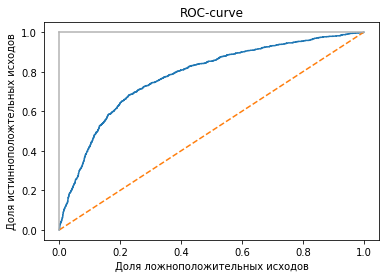

In [40]:
## Оценка модели
pred_proba_valid = best_model.predict_proba(X_valid)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_valid, pred_proba_valid[:,1])
plt.title("ROC-curve")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7")
plt.plot([1, 1], c=".7")
plt.ylabel("Доля истинноположтельных исходов")
plt.xlabel("Доля ложноположительных исходов")
plt.show()

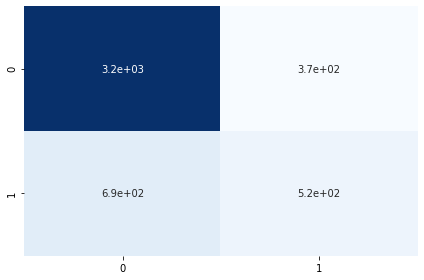

In [41]:
pred_valid = best_model.predict(X_valid)
matrix = confusion_matrix(y_valid, pred_valid)
dataframe = pd.DataFrame(matrix)

#Создать тепловую карту
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues")
plt.tight_layout()


In [49]:
#Сохранение модели
joblib.dump(best_model.best_params_, 'cat_model_classifier.pkl', compress = 1)

['cat_model_classifier.pkl']